Google Drive 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Install dependencies

In [ ]:
!pip install livelossplot -q

# Imports

In [ ]:
import tensorflow as tf
from pathlib import Path
from os.path import abspath
import pandas as pd
import os
from livelossplot import PlotLossesKeras

available_gpus = tf.config.list_physical_devices('GPU')
print(f"Number of available GPUs: {len(available_gpus)}")

try:
    tf.config.experimental.set_memory_growth(available_gpus[0], True)
except:
    pass

Number of available GPUs: 1


# Paths

In [ ]:
SRC_DIR = Path('/content/drive/MyDrive/TAI/III/nlp/')
DATA_DIR = SRC_DIR / "data"
LOG_DIR = SRC_DIR / 'logs'
BEST_MODEL_DIR = LOG_DIR / "checkpoints"
TENSOR_BOARD_DIR = LOG_DIR / "tensor_board"

# Dataset

## Load dataset

In [ ]:
dataset_df = pd.read_csv(os.path.join(DATA_DIR, "dataset.csv"))

## Dataset info

In [ ]:
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105354 entries, 0 to 105353
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   id               105354 non-null  int64 
 1   followers_count  105354 non-null  int64 
 2   verified         105354 non-null  bool  
 3   reactions_count  105354 non-null  int64 
 4   retweet_count    105354 non-null  int64 
 5   text             105354 non-null  object
 6   source           105354 non-null  object
 7   description      89892 non-null   object
 8   replies_count    105354 non-null  int64 
 9   fake             105354 non-null  bool  
dtypes: bool(2), int64(5), object(3)
memory usage: 6.6+ MB


In [ ]:
dataset_df.head()

,id,followers_count,verified,reactions_count,retweet_count,text,source,description,replies_count,fake
0,498254340310966273,1080,False,53,286,Michael Brown is the 17 yr old boy who was sho...,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",Sr.Lecturer @IEDP_PennGSE | GlobalDev + Migrat...,0,True
1,498260814487642112,1639,False,1,1,@AmeenaGK @jaythenerdkid And how long before a...,"<a href=""http://twitter.com/download/iphone"" r...",#TeamRocketRaccoon #TeamEternia #TeamEtheria #...,0,True
2,498261272174284801,6612,False,0,0,@d_m_elms @AmeenaGK they'll drag his entire hi...,"<a href=""http://twitter.com/download/android"" ...",muslim cis queer neuroatypical intersectional ...,0,True
3,498261302733967361,1070,False,1,2,@d_m_elms @jaythenerdkid or traces back some b...,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",Sr.Lecturer @IEDP_PennGSE | GlobalDev + Migrat...,0,True
4,498261642099326976,1639,False,5,9,@AmeenaGK @jaythenerdkid CHILD KILLED TO PROTE...,"<a href=""http://twitter.com/download/iphone"" r...",#TeamRocketRaccoon #TeamEternia #TeamEtheria #...,0,True


In [ ]:
dataset_df['fake'].value_counts()

False    72229
True     33125
Name: fake, dtype: int64

Duplicates and NaNs

In [ ]:
dataset_df.duplicated().sum()

0

In [ ]:
dataset_df.isnull().sum()

id                     0
followers_count        0
verified               0
reactions_count        0
retweet_count          0
text                   0
source                 0
description        15462
replies_count          0
fake                   0
dtype: int64

## Clean data

### Drop NaNs

In [ ]:
dataset_df = df = dataset_df.fillna('')

## Map type to int

In [ ]:
mapping = {False: 0, True: 1}
dataset_df['class'] = dataset_df['fake']
dataset_df = dataset_df.replace({'class': mapping})

## Merge title and text

In [ ]:
dataset_df['text_combined'] = dataset_df['text'] + ' ' + dataset_df['description']

In [ ]:
dataset_df.head()

,id,followers_count,verified,reactions_count,retweet_count,text,source,description,replies_count,fake,class,text_combined
0,498254340310966273,1080,False,53,286,Michael Brown is the 17 yr old boy who was sho...,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",Sr.Lecturer @IEDP_PennGSE | GlobalDev + Migrat...,0,True,1,Michael Brown is the 17 yr old boy who was sho...
1,498260814487642112,1639,False,1,1,@AmeenaGK @jaythenerdkid And how long before a...,"<a href=""http://twitter.com/download/iphone"" r...",#TeamRocketRaccoon #TeamEternia #TeamEtheria #...,0,True,1,@AmeenaGK @jaythenerdkid And how long before a...
2,498261272174284801,6612,False,0,0,@d_m_elms @AmeenaGK they'll drag his entire hi...,"<a href=""http://twitter.com/download/android"" ...",muslim cis queer neuroatypical intersectional ...,0,True,1,@d_m_elms @AmeenaGK they'll drag his entire hi...
3,498261302733967361,1070,False,1,2,@d_m_elms @jaythenerdkid or traces back some b...,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",Sr.Lecturer @IEDP_PennGSE | GlobalDev + Migrat...,0,True,1,@d_m_elms @jaythenerdkid or traces back some b...
4,498261642099326976,1639,False,5,9,@AmeenaGK @jaythenerdkid CHILD KILLED TO PROTE...,"<a href=""http://twitter.com/download/iphone"" r...",#TeamRocketRaccoon #TeamEternia #TeamEtheria #...,0,True,1,@AmeenaGK @jaythenerdkid CHILD KILLED TO PROTE...


## Split dataset to train, val and test

Function

In [ ]:
from sklearn.model_selection import train_test_split
def split_data(data, labels, valid_part_size = 0.15, test_part_size = 0.15):

    # Split the dataset into train, validation, and test
    X_train, X_test, y_train, y_test = train_test_split(
        data, 
        labels, 
        test_size = test_part_size, 
        stratify = labels, 
        random_state = 1234
        )
    
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, 
        y_train, 
        test_size = valid_part_size/(1 - test_part_size), 
        stratify = y_train, 
        random_state = 1234
        )

    return (X_train, y_train), (X_val, y_val), (X_test, y_test)

In [ ]:
(X_train, y_train), (X_val, y_val), (X_test,y_test) = split_data(
    dataset_df['text_combined'], 
    dataset_df['class'], 
    0.15, 
    0.15
)

### Convert X to list

In [ ]:
X_train =  tf.constant(X_train, dtype=tf.string)
X_test =  tf.constant(X_test, dtype=tf.string)
X_val =  tf.constant(X_val, dtype=tf.string)

### Convert Y to categorical

In [ ]:
y_train = tf.constant(y_train, dtype='float32')
y_test = tf.constant(y_test, dtype='float32')
y_val = tf.constant(y_val, dtype='float32')

# Model

## Parameters

In [ ]:
BATCH_SIZE = 256
EPOCHS = 100
TEST_SPLIT = 0.15
VALID_SPLIT = 0.15
SEED = 1234
VOCABULARY_SIZE = 100000
MAX_SEQUENCE_LEN = 250
EMBEDDING_DIM = 75

## Vectorization layer

In [ ]:
vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=VOCABULARY_SIZE,
    standardize='lower',
    split='whitespace',
    ngrams=None,
    output_mode='int',
    output_sequence_length=MAX_SEQUENCE_LEN,
)
vectorize_layer.adapt(X_train, batch_size=BATCH_SIZE)

## Model architecture

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1,), dtype=tf.string),
    vectorize_layer,
    tf.keras.layers.Embedding(input_dim=VOCABULARY_SIZE, output_dim=EMBEDDING_DIM),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(1028, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 250)              0         
 torization)                                                     
                                                                 
 embedding_2 (Embedding)     (None, 250, 75)           7500000   
                                                                 
 bidirectional_4 (Bidirectio  (None, 250, 2056)        9079296   
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 256)              2237440   
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                      

## Metrics

In [ ]:
METRICS = [
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.AUC(name='auc'),
    ]

## Compile

In [ ]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics= METRICS 
)

## Callbacks

In [ ]:
BEST_MODEL_FILE = BEST_MODEL_DIR / "lstm002_best"

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, verbose=1, min_delta=0.001)
save_best = tf.keras.callbacks.ModelCheckpoint(filepath=BEST_MODEL_FILE, monitor='val_loss', save_best_only=True)
csv_logger = tf.keras.callbacks.CSVLogger(filename=LOG_DIR / "history2.csv")
tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=str(TENSOR_BOARD_DIR.resolve()))

## Train

In [35]:
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=[save_best, early_stop, csv_logger],
    )

Epoch 1/100
289/289 [==============================] - ETA: 0s - loss: 0.3743 - accuracy: 0.8184 - recall: 0.6001 - precision: 0.7714 - auc: 0.8757

289/289 [==============================] - 579s 2s/step - loss: 0.3743 - accuracy: 0.8184 - recall: 0.6001 - precision: 0.7714 - auc: 0.8757 - val_loss: 0.2757 - val_accuracy: 0.8773 - val_recall: 0.7219 - val_precision: 0.8656 - val_auc: 0.9485
Epoch 2/100
289/289 [==============================] - ETA: 0s - loss: 0.1737 - accuracy: 0.9272 - recall: 0.8843 - precision: 0.8842 - auc: 0.9785

289/289 [==============================] - 569s 2s/step - loss: 0.1737 - accuracy: 0.9272 - recall: 0.8843 - precision: 0.8842 - auc: 0.9785 - val_loss: 0.2596 - val_accuracy: 0.8849 - val_recall: 0.7692 - val_precision: 0.8505 - val_auc: 0.9533
Epoch 3/100
289/289 [==============================] - 545s 2s/step - loss: 0.0964 - accuracy: 0.9620 - recall: 0.9406 - precision: 0.9387 - auc: 0.9930 - val_loss: 0.3009 - val_accuracy: 0.8822 - val_recall: 0.8112 - val_precision: 0.8135 - val_auc: 0.9472
Epoch 4/100
289/289 [==============================] - 543s 2s/step - loss: 0.0603 - accuracy: 0.9777 - recall: 0.9664 - precision: 0.9628 - auc: 0.9968 - val_loss: 0.3985 - val_accuracy: 0.8731 - val_recall: 0.7851 - val_precision: 0.8062 - val_auc: 0.9337
Epoch 5/100
289/289 [==============================] - 542s 2s/step - loss: 0.0375 - accuracy: 0.9855 - recall: 0.9777 - precision: 0.9762 - auc: 0.9987 - val_loss: 0.4680 - val_accuracy: 0.8711 - val_recall: 0.8050 - val_precision: 0.789

## Plot metrics history

In [36]:
import matplotlib.pyplot as plt

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_metrics(history, metric_names):
  for n, metric in enumerate(metric_names):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(3,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()



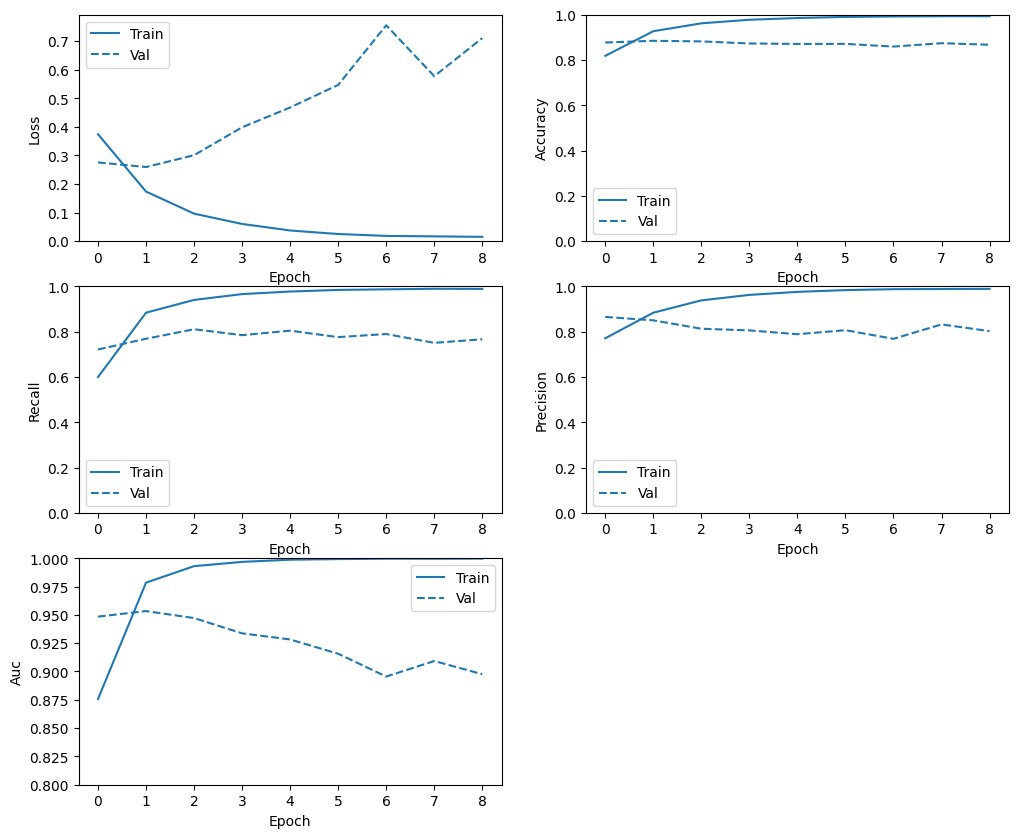

In [37]:
metrics = ["loss", 'accuracy', 'recall', 'precision', 'auc']
plt.figure(figsize=(12,10))
plot_metrics(history, metrics)

# Evaluation

In [38]:
model.evaluate(X_test, y_test)

494/494 [==============================] - 51s 103ms/step - loss: 0.7242 - accuracy: 0.8641 - recall: 0.7583 - precision: 0.7992 - auc: 0.8947


[0.7242254018783569,
 0.8640850186347961,
 0.7583014965057373,
 0.7991516590118408,
 0.8947398662567139]